<a href="https://colab.research.google.com/github/smozley/austinAIallianceintensive/blob/main/multi_agent_orchestration_tutorial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial guides you through building a hierarchical, multi-agent system from scratch. You will create a five-agent "Press Release Team" orchestrated by a supervisor agent powered by Granite. This supervisor will manage a team of four specialized worker agents—a mix of Granite and Mistral models—who will collaborate in parallel to draft a press release.

The entire process uses LangGraph for orchestration, local models via Ollama, and Langfuse for complete end-to-end observability, providing a comprehensive template for building sophisticated AI agent teams.

### **Step 1: Setup and Installation**

### Setting up Ollama (in the terminal window)

1. Install the dependencies

```
sudo apt update
sudo apt install -y pciutils
curl -fsSL https://ollama.com/install.sh | sh
```

2. Run the ollama server in the background

```
ollama serve &
```

3. Pull the required models

```
ollama pull granite3.3:latest
ollama pull mistral:latest
```

4. Run the models in the background

```
ollama run granite3.3:latest &
ollama run mistral:latest &
```

### Installing the necessary libraries

In [1]:
# Install all required packages
!pip install -qU langgraph langchain_openai langchain_community langchain-tavily langfuse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.



### **Step 2: Configure Langfuse & API Keys**

Next, we'll set up our credentials. You will need API keys from **Langfuse** (for observability) and **Tavily** (for the web search tool).

In [2]:
import os
from getpass import getpass
from langfuse import Langfuse

#  Langfuse Configuration for Observability
# Get keys from your Langfuse project at https://cloud.langfuse.com
if "LANGFUSE_PUBLIC_KEY" not in os.environ:
    os.environ["LANGFUSE_PUBLIC_KEY"] = getpass("Enter your Langfuse Public Key: ")
if "LANGFUSE_SECRET_KEY" not in os.environ:
    os.environ["LANGFUSE_SECRET_KEY"] = getpass("Enter your Langfuse Secret Key: ")
if "LANGFUSE_HOST" not in os.environ:
    os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com"

# Initialize the Langfuse handler which will trace our runs
langfuse_handler = Langfuse()

#  Tavily API Key for the search tool
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass("Enter your Tavily API key: ")

Enter your Langfuse Public Key: ··········
Enter your Langfuse Secret Key: ··········
Enter your Tavily API key: ··········




### **Step 3: Initialize Models and Tools**

We will configure our LLMs using the `ChatOpenAI` wrapper. This allows us to use LangChain's powerful tool-calling features with our local Ollama models.

In [3]:
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch

#  Common Ollama Configuration
OLLAMA_BASE_URL = "http://localhost:11434/v1"
DUMMY_API_KEY = "ollama"

granite_supervisor_llm = ChatOpenAI(
    model="granite3.3:latest",
    api_key=DUMMY_API_KEY,
    base_url=OLLAMA_BASE_URL,
    temperature=0
)

granite_worker_llm = ChatOpenAI(
    model="granite3.3:latest",
    api_key=DUMMY_API_KEY,
    base_url=OLLAMA_BASE_URL,
    temperature=0
)

mistral_worker_llm = ChatOpenAI(
    model="mistral:latest",
    api_key=DUMMY_API_KEY,
    base_url=OLLAMA_BASE_URL,
    temperature=0.3
)

#  Tool Definition
# The Market Analyst is the only role that needs a web search tool
search_tool = TavilySearch(max_results=2)

### **Step 4: Define Agent State and Roles**

Next, we define the shared `state` for our graph and create the specific agent `roles`. The `agent_map` is crucial for routing tasks to the correct model and tool configuration.

In [4]:
from typing import TypedDict, List, Dict, Annotated
import operator
from pydantic import BaseModel, Field

#  Define the structure of a task
class Task(BaseModel):
    """A task assigned to a specific role on the press release team."""
    role: str = Field(description="The role responsible for the task.")
    description: str = Field(description="A detailed description of the task.")

#  Define a Pydantic model to wrap the list of tasks
class Tasks(BaseModel):
    """A list of tasks."""
    tasks: List[Task] = Field(description="The list of tasks.")

#  Define the graph's state
class TeamState(TypedDict):
    product_info: str
    tasks: List[Task]
    press_release_components: Annotated[List[Dict[str, str]], operator.add]
    final_press_release: str

#  Define Agent Runnables and Role Mapping
# Agent with search tools (Granite)
research_agent_runnable = granite_worker_llm.bind_tools([search_tool])
# Agent for creative writing (Mistral)
creative_agent_runnable = mistral_worker_llm
# Agent for analytical/review tasks without tools (Granite)
analytical_agent_runnable = granite_worker_llm

# Map roles to their specific agent runnable and tools
agent_map = {
    "Product Specialist": analytical_agent_runnable,
    "Market Analyst": research_agent_runnable,
    "Quote Writer": creative_agent_runnable,
    "Legal Reviewer": analytical_agent_runnable
}



### **Step 5: Define Nodes and Supervisor Logic**

We'll define two main nodes: a generic `worker_node` that can perform any of the four worker tasks, and the `PRDirector` supervisor node that orchestrates the entire process.

In [5]:
from langchain_core.messages import HumanMessage

#  Worker Node Definition
def worker_node(task: dict) -> dict:
    """A generic worker node that executes tasks based on the assigned role."""
    # Rehydrate into your Pydantic Task model
    task = Task(**task)

    agent_runnable = agent_map[task.role]
    print(f" Worker '{task.role}' starting task... ")

    # Invoke the correct agent with the task description
    result = agent_runnable.invoke([HumanMessage(content=task.description)])

    # If the agent made a tool call, execute it
    if hasattr(result, "tool_calls") and result.tool_calls:
        tool_call = result.tool_calls[0]
        output = search_tool.invoke(tool_call["args"])
    else:
        output = result.content

    # Return the component in the shape expected by your reducer
    return {
        "press_release_components": [
            {"role": task.role, "component": str(output)}
        ]
    }

#  Supervisor Node Definition
class PRDirector:
    """The supervisor agent, powered by Granite 3.3."""
    def __init__(self, llm):
        self.llm = llm
        # Use the new Tasks model for structured output
        self.structured_llm = llm.with_structured_output(Tasks)

    def __call__(self, state: TeamState):
        if not state.get('tasks'):
            # First step: Decompose the request into tasks for the 4 workers
            print(" PR Director (Granite): Decomposing request... ")
            prompt = f"""You are the PR Director for a major tech company. A new product launch is imminent.
            Based on the following product info, create four specific tasks for your team:
            1. 'Product Specialist': Summarize the key features and specs into 3-4 bullet points.
            2. 'Market Analyst': Research how two major competitors are positioning similar products.
            3. 'Quote Writer': Draft a creative and exciting quote from the CEO about this launch.
            4. 'Legal Reviewer': Write a standard legal disclaimer for press releases about forward-looking statements.

            Provide the output as a JSON object with a single key 'tasks' containing a list of task objects.

            Product Info: {state['product_info']}"""
            # The output will be a Tasks object, so extract the tasks list
            tasks = self.structured_llm.invoke(prompt).tasks
            return {"tasks": tasks}
        else:
            # Final step: Aggregate components and write the final press release
            print(" PR Director (Granite): Synthesizing final press release... ")
            components = "\n\n\n\n".join(
                f"### Component from {res['role']}:\n{res['component']}"
                for res in state['press_release_components']
            )
            prompt = f"""You are the PR Director. Your team has provided all the necessary components for the press release.
            Assemble them into a final, professional, and compelling press release document.
            Ensure it has a catchy headline, a strong introduction, incorporates the product features and CEO quote smoothly, and ends with the legal disclaimer.

            Team's Components:
            {components}"""
            final_press_release = self.llm.invoke(prompt).content
            return {"final_press_release": final_press_release}



### **Step 6: Construct the Hierarchical Graph**

Now we wire the nodes together. LangGraph's `.map()` feature is key here, as it allows us to run our four worker tasks in parallel.

In [6]:
from langgraph.graph import StateGraph, END
from langgraph.types import Send
from langchain_core.messages import HumanMessage

# helper to slugify role names
def slug(role: str) -> str:
    return role.lower().replace(" ", "_")

# Build the graph
workflow = StateGraph(TeamState)
workflow.add_node("pr_director", PRDirector(granite_supervisor_llm))

# Add one worker‐node per role
for role, runnable in agent_map.items():
    node_name = slug(role)

    def make_worker(runnable):
        # This inner fn will be the actual node
        def _worker(task_data: dict) -> dict:
            # 1) rehydrate into your Task model
            task = Task(**task_data)

            # 2) pick the right LLM/tools
            agent = runnable
            print(f" 👷 Worker '{task.role}' starting task... ")

            # 3) invoke and possibly call the search tool
            result = agent.invoke([HumanMessage(content=task.description)])
            if getattr(result, "tool_calls", None):
                call = result.tool_calls[0]
                output = search_tool.invoke(call["args"])
            else:
                output = result.content

            # 4) return in the reducer‐friendly shape
            return {
                "press_release_components": [
                    {"role": task.role, "component": str(output)}
                ]
            }
        return _worker

    workflow.add_node(node_name, make_worker(runnable))

# Entry point
workflow.set_entry_point("pr_director")

# Fan‐out to each role‐node
def fan_out_tasks(state: TeamState):
    # only dispatch once
    if not state.get("tasks") or state.get("press_release_components"):
        return []

    product_info = state["product_info"]
    sends: list[Send] = []
    for task in state["tasks"]:
        node_name = slug(task.role)
        # build a description that includes both the context & the instruction
        description = (
            f"Product Info:\n{product_info}\n\n"
            f"Your assignment: {task.description}"
        )
        sends.append(
            Send(
                node_name,
                {
                    "role":        task.role,
                    "description": description,
                },
            )
        )
    return sends

workflow.add_conditional_edges(
    "pr_director",
    fan_out_tasks,
    [slug(r) for r in agent_map],
)

# Fan‐in: every role‐node wires back to the director
for role in agent_map:
    workflow.add_edge(slug(role), "pr_director")

# Terminate when final_press_release exists
workflow.add_conditional_edges(
    "pr_director",
    lambda s: END if s.get("final_press_release") else [],
)

graph = workflow.compile()


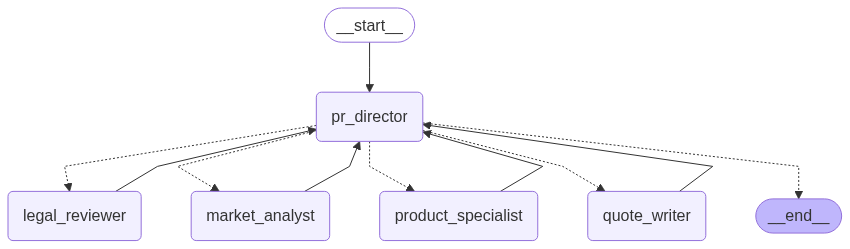

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



### **Step 7: Run the Team with Full Observability**

Finally, let's give our AI team a product to launch and observe their work in Langfuse.

In [8]:
from langchain_core.runnables import RunnableConfig
from langfuse import get_client
from langfuse.langchain import CallbackHandler
from langgraph.errors import GraphRecursionError

client            = get_client()
langfuse_handler  = CallbackHandler()

config = RunnableConfig(
    callbacks=[langfuse_handler],
    recursion_limit=5,
    configurable={
        "session_id": "press-release-team-run-1",
        "thread_id":  "press-release-team-thread-1"
    }
)

initial_state = {
    "product_info": (
        "Product Name: 'Chronos-1'. Category: Smartwatch. "
        "Key Features: 7-day battery life, advanced sleep tracking with REM analysis, "
        "solar charging, titanium casing, integrated AI assistant for real-time translation."
    ),
    "press_release_components": [],
    "tasks": [],
}

print(" Launching…")
try:
    final_state = graph.invoke(initial_state, config=config)
    client.flush()

    #sid = config.configurable["session_id"]
    #print(f"🔗 View your run in Langfuse: https://us.cloud.langfuse.com/app/<YOUR-PROJECT-ID>/sessions/{sid}")

except GraphRecursionError as e:
    print(f"⚠️ Recursion limit reached: {e}")
    client.flush()

    #sid = config.configurable["session_id"]
    #print(f"🔗 View partial run in Langfuse: https://us.cloud.langfuse.com/app/<YOUR-PROJECT-ID>/sessions/{sid}")

    # fetch the last persisted state
    snapshot = graph.get_state(config)
    partial = snapshot.values.get("press_release_components", [])

    partial_release = "\n\n\n\n".join(
        f"### Component from {c['role']}:\n{c['component']}"
        for c in partial
    )

    print("\n PARTIAL RELEASE:")
    print(partial_release)

    final_state = {"final_press_release": partial_release}

print("\n" + "="*60)
print("✅ FINAL PRESS RELEASE")
print("="*60)
print(final_state["final_press_release"])


 Launching…
 PR Director (Granite): Decomposing request... 
 👷 Worker 'Product Specialist' starting task...  👷 Worker 'Market Analyst' starting task... 

 👷 Worker 'Quote Writer' starting task... 
 👷 Worker 'Legal Reviewer' starting task... 
 PR Director (Granite): Synthesizing final press release... 

✅ FINAL PRESS RELEASE
**FOR IMMEDIATE RELEASE**

**Chronos Inc. Unveils Chronos-1: The Future of Wearable Technology**

[City, State] – [Date] – Chronos Inc., a leader in innovative wearable technology, is thrilled to announce the launch of its groundbreaking product, the Chronos-1 smartwatch. This revolutionary device transcends traditional timekeeping by integrating cutting-edge features designed to enhance users' lifestyles and wellbeing.

The Chronos-1 boasts an impressive 7-day battery life, setting it apart from competitors in the market. With advanced sleep tracking capabilities that include REM analysis, this smartwatch offers comprehensive insights into sleep quality and stages,